In [1]:
import pandas as pd
import cv2
from tqdm import tqdm
import ast
from sklearn import model_selection
import numpy as np
import os
import shutil

In [2]:
!git clone https://github.com/ultralytics/yolov5
!mv yolov5/* ./
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 6294, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 6294 (delta 41), reused 59 (delta 24), pack-reused 6205
Receiving objects: 100% (6294/6294), 8.54 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (4300/4300), done.
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272455 sha256=7a3af4e2094a3cf118da5a6773866b1ff7810e48e68c6631308e994d814f6a70
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [3]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [4]:
!mkdir new_data

In [5]:
train_df = pd.read_csv('../input/payment-detection/train.csv')
new_imgs = []
new_boxes = []
cards = {
    'VI':0,
    'MA':1,
    'EX':2, 
    'PC':3, 
    'ST':4,
    'UY':5
        }

for _,row in tqdm(train_df.iterrows()):
    label = cards[row['label']]
    x = int(row['x1'] * (1280/row['width']))
    y = int(row['y1'] * (1280/row['height']))
    w = int(row['w'] * (1280/row['width']))
    h = int(row['h'] * (1280/row['height']))
    img_name = row['image']
    temp_img = cv2.imread('../input/payment-detection/train/train/'+img_name)
    #temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    temp_img = cv2.resize(temp_img,(1280,1280))

    cv2.imwrite('./new_data/'+img_name,temp_img)
    new_imgs.append(img_name)
    new_boxes.append([label,x,y,w,h])

3310it [02:32, 21.77it/s]


In [6]:
!mkdir new_data_test
TEST_PATH = '../input/payment-detection/test/test/'
for item in tqdm(os.listdir('../input/payment-detection/test/test/')):
    temp_img = cv2.imread(TEST_PATH+item)
    #temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    temp_img = cv2.resize(temp_img,(1280,1280))
    cv2.imwrite('new_data_test/'+item,temp_img)

100%|██████████| 982/982 [00:43<00:00, 22.65it/s]


In [7]:
clean_train_df = pd.DataFrame(zip(new_imgs,new_boxes),columns = ['image_id','bbox'])
clean_train_df['image_id'] = clean_train_df['image_id'].apply(lambda x: x.split('.')[0])
clean_train_df

,image_id,bbox
0,fea9aa88a2b6c3803f40c5323343a21c,"[0, 433, 859, 76, 129]"
1,7bcc43c3f9d6a6c19d34dabbdbdb95da,"[3, 892, 928, 276, 156]"
2,2cbd841c8a6bc7aca3747e7303bb4c6c,"[1, 872, 857, 315, 263]"
3,e6757a49d92fda04ba0e0ad248f20f64,"[0, 939, 982, 314, 182]"
4,554ba2ee67495dbfa025f48a4a4b3fee,"[0, 898, 968, 286, 266]"
...,...,...
3305,67e8d93d85c4c08222167fd97dc8bfdd,"[0, 287, 418, 281, 293]"
3306,67e8d93d85c4c08222167fd97dc8bfdd,"[0, 771, 775, 275, 253]"
3307,67e8d93d85c4c08222167fd97dc8bfdd,"[0, 199, 1098, 185, 181]"
3308,67e8d93d85c4c08222167fd97dc8bfdd,"[2, 683, 511, 277, 248]"


In [8]:
type(clean_train_df.iloc[1].bbox)

list

In [9]:
#clean_train_df.bbox = clean_train_df.bbox.apply(ast.literal_eval)
df = clean_train_df.groupby('image_id')['bbox'].apply(list).reset_index(name='bboxes')
df_train,df_valid = model_selection.train_test_split(
    df,
    test_size = 0.1,
    random_state = 42,
    shuffle = True
)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [11]:
!mkdir card_data
!mkdir card_data/images
!mkdir card_data/labels
!mkdir card_data/images/train
!mkdir card_data/images/validation
!mkdir card_data/labels/train
!mkdir card_data/labels/validation
!tree card_data

card_data
├── images
│   ├── train
│   └── validation
└── labels
    ├── train
    └── validation

6 directories, 0 files


In [12]:
DATA_PATH = './new_data/'
OUTPUT_PATH = './card_data/'
def process_data(data,data_type="train"):
    for _,row in tqdm(data.iterrows(),total=len(data)):
        image_name = row['image_id']
        bounding_boxes = row['bboxes']
        yolo_data = []
        for bbox in bounding_boxes:
            x = bbox[1]
            y = bbox[2]
            w = bbox[3]
            h = bbox[4]
            label = bbox[0]
            x_center = x + w / 2
            y_center = y + h / 2
            x_center /= 1280.0
            y_center /= 1280.0
            w /= 1280.0
            h /= 1280.0
            yolo_data.append([label, x_center, y_center, w, h])
        yolo_data = np.array(yolo_data)
        np.savetxt(
            os.path.join(OUTPUT_PATH, f"labels/{data_type}/{image_name}.txt"),
            yolo_data,
            fmt=["%d", "%f", "%f", "%f", "%f"]
        )
        shutil.copyfile(
            os.path.join(DATA_PATH, f"{image_name}.jpg"),
            os.path.join(OUTPUT_PATH, f"images/{data_type}/{image_name}.jpg")
        )
        
process_data(df_train,data_type = "train")
process_data(df_valid,data_type = "validation")

100%|██████████| 188/188 [00:00<00:00, 1204.89it/s]


In [13]:
#Создаём конфиг
with open('card.yaml','w+') as f:
    f.write('train: ./card_data/images/train\n')
    f.write('val : ./card_data/images/validation\n')
    f.write('nc: 6\n')
    f.write('names: ["VI","MA","EX","PC","ST","UY"]')

In [14]:
!cat 'card.yaml'

train: ./card_data/images/train
val : ./card_data/images/validation
nc: 6
names: ["VI","MA","EX","PC","ST","UY"]

In [15]:
ls models

__init__.py  experimental.py  hub/     yolov5l.yaml  yolov5s.yaml
common.py    export.py        yolo.py  yolov5m.yaml  yolov5x.yaml


In [16]:
import wandb
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient() 

personal_key_for_api = '5f9c88df1464fae268d899182385bde5772a5365'

! wandb login $personal_key_for_api

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
!python train.py --img 1280 --batch 4 --epochs 45 --data card.yaml --name may9x6 --weights yolov5x6.pt --cache --notest

github: skipping check (not a git repository)
2021-05-16 07:08:00.152627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
wandb: Currently logged in as: michosi (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-05-16 07:08:05.331856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-05-16 07:08:05.334207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
wandb: Tracking run with wandb version 0.10.23
wandb: Syncing run may9x6
wandb: ⭐️ View project at https://wandb.ai/michosi/YOLOv5
wandb: 🚀 View run at https://wandb.ai/michosi/YOLOv5/runs/3pmzv9pb
wandb: Run data is saved locally in /kaggle/working/wandb/run-20210516_070803-3pmzv9pb
wandb: Run `wandb offline` to turn off 

In [18]:
import torch
with torch.no_grad():
    torch.cuda.empty_cache()
!nvidia-smi


Sun May 16 13:44:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
!du -sh

3.8G	.


In [21]:
!ls ./runs/train

may9x6


In [22]:
!python detect.py --source ./new_data_test --weights runs/train/may9x6/weights/best.pt --img 1280 --save-txt --save-conf --conf-thres 0.45 --iou-thres 0.30 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.45, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=1280, iou_thres=0.3, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=True, save_crop=False, save_txt=True, source='./new_data_test', update=False, view_img=False, weights=['runs/train/may9x6/weights/best.pt'])
image 1/982 /kaggle/working/new_data_test/00423e14be0f133c8770f8abd6934faf.jpg: 1280x1280 1 EX, Done. (0.142s)
image 2/982 /kaggle/working/new_data_test/006d4217463fec75177221e10d3f84d3.jpg: 1280x1280 1 VI, Done. (0.132s)
image 3/982 /kaggle/working/new_data_test/00b6322a7efbb132f81fe83f5445def4.jpg: 1280x1280 1 VI, Done. (0.131s)
image 4/982 /kaggle/working/new_data_test/00f01cf070b0c5f050c710ca8e6464fb.jpg: 1280x1280 1 MA, Done. (0.131s)
image 5/982 /kaggle/working/new_data_test/01087b8a71b1ee6e78d3cfa2567bd28f.jpg: 1280x1280 Done. (0.130s)
image 6/982 /kaggle/working/new_data_test/0148bae16b82b74f1669a8

In [ ]:
!cat runs/detect/exp3/labels/00423e14be0f133c8770f8abd6934faf.txt

738abc67d19501193adbe02791139120.jpg
1 0.796875 0.671875 0.2625 0.389062 0.773926


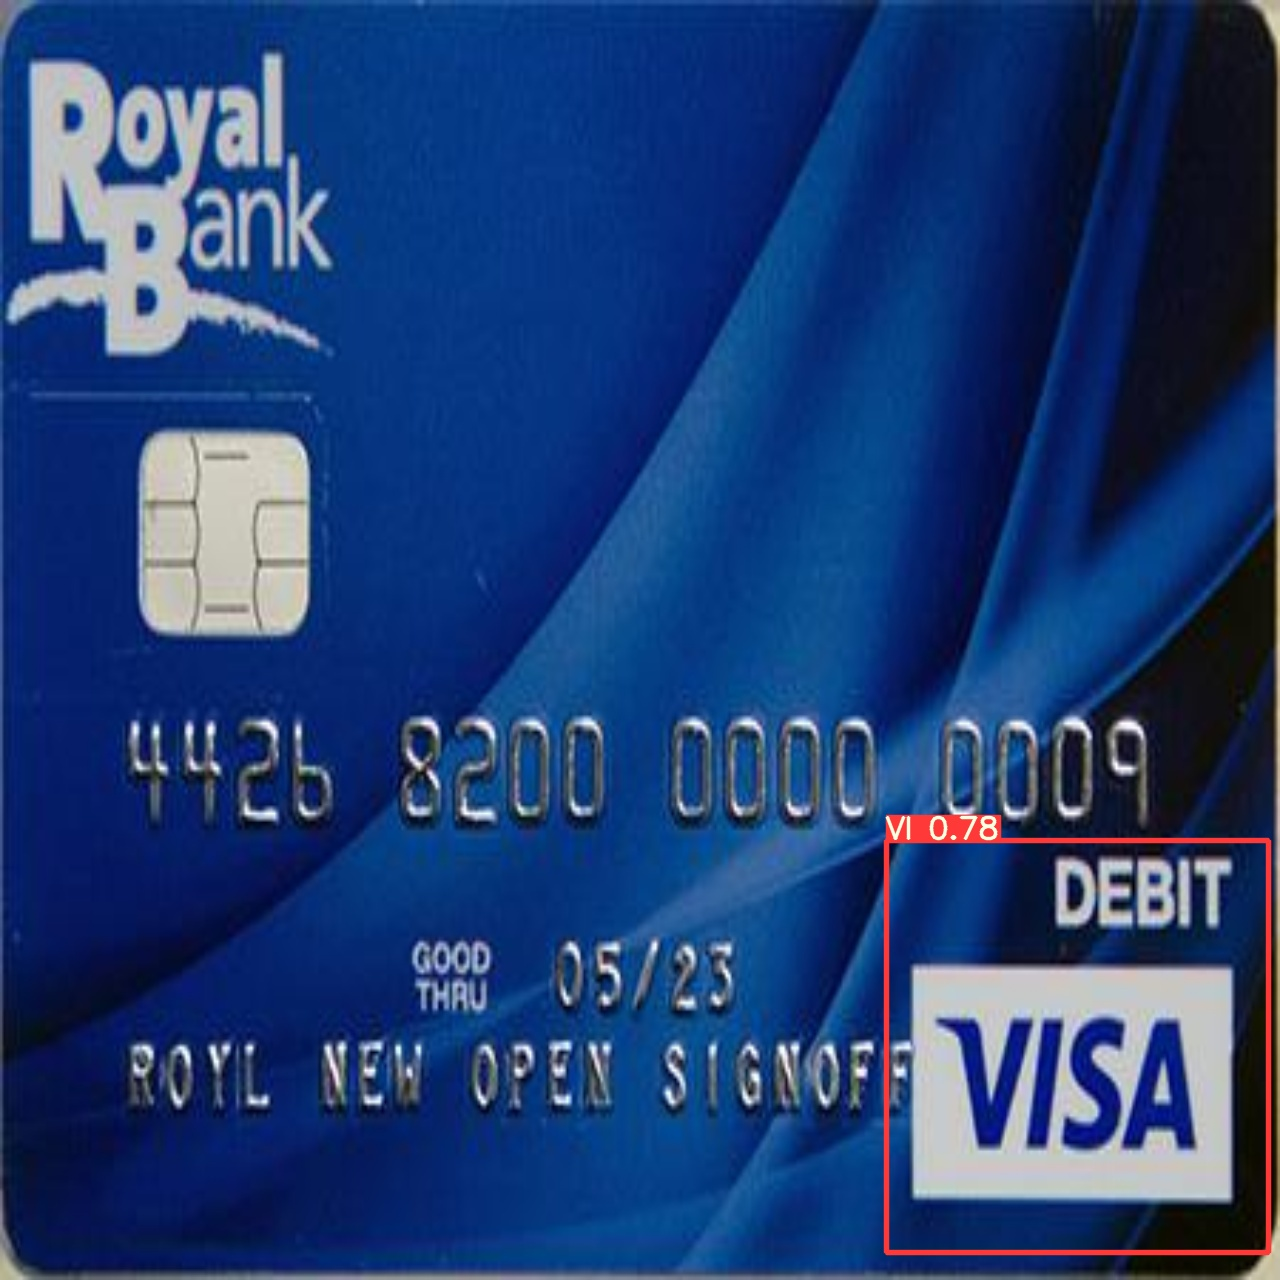

In [23]:
#!ls runs/detect/exp
from IPython.display import Image
files = os.listdir('runs/detect/exp/')

print(files[528])
!cat runs/detect/exp/labels/ffefed2d2c1540298f537548f281bd0e.txt
Image("runs/detect/exp/" + files[794])

In [61]:
labels = os.listdir('runs/detect/exp/labels/')
image = []
lenght = []
for item in labels:
    with open('runs/detect/exp/labels/' + item,'r') as f:
        #print((f.readlines()))
        image.append(item)
        lenght.append(f.readlines())
result_pd = pd.DataFrame(zip(image,lenght), columns = ['image','labels'])
result_pd.to_csv('result.csv')

In [62]:
def c_sort(sub_li):
        """
        Сортировка боксов по координатам. Слева направо сверху вниз.
        """
        sub_li.sort(key = lambda x: (x[1], x[2]))
        return sub_li
cards = {
    0:'VI',
    1:'MA',
    2:'EX', 
    3:'PC', 
    4:'ST',
    5:'UY'
        }
      

In [64]:
import re
# Тут width, height = 640. Улучшает результат.
subs_yolo = pd.read_csv('./result.csv').drop(columns='Unnamed: 0')
!rm ./result.csv
boxes_yolo = {}
for ind,row in subs_yolo.iterrows():
    im = row['image'].replace('.txt','.jpg')
    width = 640
    height = 640
    boxes = row['labels'].replace('[','').replace(']','').replace('\n','').replace("'",'').replace('\\n','')
    res_boxes = []
    if ',' in boxes:
        temp_boxes = boxes.split(',')
        for box in temp_boxes:
            if box[0] == ' ':
                box = box[1:]
            boxes = box.split(' ')
            x_c = int(float(boxes[1])*float(width))
            y_c = int(float(boxes[2]) * float(height))
            xmin = int(int(x_c) - ((int(width)*float(boxes[3]))/2))
            ymin = int(int(y_c) - ((int(height)*float(boxes[4]))/2))
            xmax = int(int(x_c) + ((int(width)*float(boxes[3]))/2))
            ymax = int(int(y_c) + ((int(height)*float(boxes[4]))/2))
            label = cards[int(boxes[0])]
            res_boxes.append([label,xmin,ymin,xmax,ymax])
        
    else:
        temp_boxes = boxes.split(' ')
        x_c = int(int(float(temp_boxes[1])*float(width)))
        y_c = int(int(float(temp_boxes[2]) * float(height)))
        xmin = int(int(x_c) - ((int(width)*float(temp_boxes[3]))/2))
        ymin = int(int(y_c) - ((int(height)*float(temp_boxes[4]))/2))
        xmax = int(int(x_c) + ((int(width)*float(temp_boxes[3]))/2))
        ymax = int(int(y_c) + ((int(height)*float(temp_boxes[4]))/2))
        label = cards[int(temp_boxes[0])]
        res_boxes.append([label,xmin,ymin,xmax,ymax])
    boxes_yolo[im] = c_sort(res_boxes)

In [65]:
sub = pd.read_csv('../input/payment-detection/submission.csv')
subs = {}
for ind,row in sub.iterrows():
  subs[row['image']] = row['payment']

for item in subs:
  if boxes_yolo.get(item) != None and boxes_yolo[item] != 'err':
    labels = []
    for box in boxes_yolo[item]:
      labels.append(box[0])
    subs[item] = ' '.join(labels)
  else:
    subs[item] = 'VI'

df = pd.DataFrame(list(subs.items()),columns=['image','payment'])
df.to_csv('submission.csv',index=False)
!rm -rf ./utils ./yolov5 ./data ./models ./weights ./new_data ./new_data_test ./card_data ./test.py ./LICENSE ./card.yaml ./detect.py ./__init__.py ./requirements.txt ./README.md ./hubconf.py ./train.py ./Dockerfile

In [ ]:
from IPython.display import FileLink
FileLink(r'submission.csv')

# Что могло улучшить результат.
1. Добавить дополнительную аугментацию(помимо встроенной в yolov5).
2. Довести до ума PseudoLabeling(тестировал, но результат был не стабильный).
3. Подобрать гиперпараметры.